# Semantic Similarity

In this notebook we follow a pipeline to extract relevant information from a data dump (generated by GPT).

The **Pipeline** is as follows:
* Read the Data
* Extract the Topics (We work with topics since it is easier to prototype with. Full Sentences can also be used.)
* Pre-Process the Data
* Generate Semantic Embeddings using a SentenceTransformer Model
* Perform K-Means Clustering

The last step, *Perform K-Means Clustering*, itself has a few parts:
* Optimize K for K-Means (this can be hard coded, or, as in the notebook, estimate from intertia)
* If preferred, apply Dimensionality Reduction using TSNE or PCA (this has proved to defeat the point of semantic embeddings to a large extent)
* Retrieve Cluster Assignments in the form of indexes
* Use the indexes to get the real clusters as a List of List of Strings (This is also where lexical cluster refinement has been built into)
* Print Clusters in a cohesive manner as well as the optimizations / datapoint filtering that has been done at multiple stages

In [1]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pylcs
import pandas as pd

In [2]:
# Global variables for the pipeline

red1 = None
red2 = None

In [3]:
# Read Dataset

data_path = '../data/I2_1_1000.txt'

with open(data_path,'r') as txtfile:
    biz_ideas = [line.rstrip('\n') for line in txtfile]

In [4]:
def topic(s1:str):
    
    # Returns the topic extracted from the entire output.
    
    return s1[:s1.find('.')]

In [5]:
def preprocess(data:list, refer=None):
    
    # Applies three proprocessing steps: turns every item to lower case, selects only short strings, and eliminates duplicates
    
    data = [datum.lower() for datum in data]
    processed = {}
    
    if refer:
                
        for i in range(len(data)):
            
            if len(data[i]) < 25:
                processed[data[i]] = refer[i]
        
    else:
        data_processed = [datum for datum in data if len(datum) < 25]
        processed = dict(zip(data_processed, data_processed))
        
    global red1
    red1 = (len(data) - len(processed.keys()))/len(data) * 100
    
    return processed

In [6]:
def overlap(s1:str, s2:str):
    
    # Returns the lexical overlap using longest common subsequence between two strings
    
    if len(s1) > len(s2):
        return pylcs.lcs(s1,s2)/float(len(s1))
    else:
        return pylcs.lcs(s1,s2)/float(len(s2))

In [7]:
# Clustering : KMeans

def kmeans(num_clusters:int, data:list):
    
    from sklearn.cluster import KMeans
        
    clustering_model = KMeans(n_clusters = num_clusters)
    clustering_model.fit(data)
    cluster_assignment = clustering_model.labels_

    return cluster_assignment

In [8]:
def optimize_k(data:list):
    
    # This function is used to automatically determine the optimal value of K for K-Means Clustering
    
    from sklearn.cluster import KMeans
    import math
    
    dists = []
    grads = []
    K = range(1,70)
    iner_drop = 0
    iner_last = 0
    
    for n in K:
        k_model = KMeans(n_clusters = n)
        k_model.fit(data)
        dists.append(k_model.inertia_)
        
    """ # This was an experiment to try stopping the optimization early to save time based on KMeans Inertia
        if n == 1:
            iner_last = k_model.inertia_
            grads.append(0)
        else:
            iner_drop = iner_last - k_model.inertia_
            grad = iner_drop/iner_last
            grads.append(grad)
            iner_last = k_model.inertia_
            
    for x, (y,z) in enumerate(zip(dists,grads),1):
        print(f'{x}. {y:.2f} {z:.4f}')
    """
    def calc_dist(x1,y1,a,b,c):
        return abs((a*x1 + b*y1 + c))/(math.sqrt(a**2 + b**2))
        
    a = dists[0] - dists[-1]
    b = K[-1] - K[0]
    c1 = K[0] * dists[-1]
    c2 = K[-1] * dists[0]
    c = c1 - c2
        
    dists_line = []

    for k in range(K[-1]):
        dists_line.append(calc_dist(K[k], dists[k], a, b, c))
                
    num_clusters = dists_line.index(max(dists_line))+1
        
    return num_clusters

In [9]:
# Alternative Approach: DBScan

def dbscan(data:list):
    
    from sklearn.cluster import DBSCAN
    
    clustering_model = DBSCAN(eps = 0.0375, min_samples = 3)
    clustering_model.fit(data)
    cluster_assignment = clustering_model.labels_

    return cluster_assignment

In [10]:
def reduce_dims(data, alg='tsne', num_components=2):
    
    # Used to reduce dimensions using TSNE or PCA algorithms
    
    topics_red = None
    
    if alg == 'tsne':
        
        from sklearn.manifold import TSNE

        topics_red = TSNE(n_components=num_components).fit_transform(data)
        
    elif alg == 'pca':
        
        from sklearn.decomposition import PCA
        topics_red = PCA(n_components=num_components,svd_solver='full').fit_transform(data)
            
    return topics_red

In [11]:
def get_clusters(num_clusters:int, df):
    
    # Prepares and returns clusters as list of lists
    
    clusters = []
    
    for i in range(num_clusters):
        
        clust_sent = np.where(df['Cluster'] == i)
        clust_points = []
        
        for k in clust_sent[0]:
            
            clust_points.append(df['Topic'][k])
            
        clusters.append(clust_points)
    
    return clusters

In [12]:
def refine_clusters(df, num_clusters:int, clust_col_name:str, threshold=0.7):
    
    # Eliminates lexically similar items using Longest Common Subsequence
    
    refined_clusters = pd.DataFrame()
    reductions = []

    for i in range(num_clusters):

        df_cluster = df.where(df[clust_col_name] == i+1)

        df_cluster.dropna(subset=['Text'], inplace=True)

        refined_cluster = pd.DataFrame()

        for j in range(df_cluster.shape[0]-1):
            flag = True

            for k in range(j+1,df_cluster.shape[0]):

                overlap_ = overlap(df_cluster.iloc[j]['Topic'],df_cluster.iloc[k]['Topic'])

                if overlap_ > 0.7:
                    #print('Hit')
                    flag = False
                    break

            if flag:
                    refined_cluster = refined_cluster.append(df_cluster.iloc[j])

        if df_cluster.shape[0]:
                reductions.append((df_cluster.shape[0] - refined_cluster.shape[0]) / df_cluster.shape[0])
                refined_clusters = refined_clusters.append(refined_cluster)

    global red2
    red2 = np.average(np.array(reductions))*100
    
    return refined_clusters

In [13]:
def print_clusters(num_clusters:int, df, clust_col_name:str, n=10):
    
    # Prints clusters in a cohesive manner and also displays how much redundant data has been eliminated

    for i in range(num_clusters):
        
        df_cluster = df.where(df[clust_col_name] == i+1)
        df_cluster.dropna(subset=['Text'], inplace=True)
        display(df_cluster.head(n))
        
    global red1, red2
    print(f'\nData trimmed by {red1:.2f}% in preprocessing step, and by {red2:.2f}% in cluster refinement step.\n')

In [14]:
topics_unprocessed = []

for idea in biz_ideas:

    topics_unprocessed.append(topic(idea))
    
ideas = dict(zip())

processed = preprocess(topics_unprocessed,biz_ideas)

df = pd.DataFrame(zip(processed.values(), processed.keys()))
df.columns = ['Text','Topic']

# Create a list of topics from the corpus

topics = list(df['Topic'])

In [15]:
# Generate embeddings using a pre-trained SentenceTransformer model

model = SentenceTransformer('paraphrase-mpnet-base-v2')
topics_embeddings_unprocessed = model.encode(topics_unprocessed)
topics_embeddings = model.encode(topics)

print(f'Shape of topic embeddings before pre-processing: {topics_embeddings_unprocessed.shape}')
print(f'Shape of topic embeddings after pre-processing: {topics_embeddings.shape}')

Shape of topic embeddings before pre-processing: (1000, 768)
Shape of topic embeddings after pre-processing: (487, 768)


In [16]:
# Top K similar ideas (Pre-processed but unrefined)

topic_query = 'Beauty'
query_embedding = model.encode(topic_query)

top_k = 5

cos_scores = util.pytorch_cos_sim(query_embedding, topics_embeddings)[0]
top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k]

print("Sentence:", topic_query, "\n")
print(f'Top {top_k} most similar items in corpus:\n')

for idx in top_results[0:top_k]:
    print(topics[idx], "(Score: %.4f)" % (cos_scores[idx]))

Sentence: Beauty 

Top 5 most similar items in corpus:

beauty salo (Score: 0.7252)
beauty pageant (Score: 0.5960)
beauty salon (Score: 0.5242)
beauty shop (Score: 0.5123)
a beauty salon (Score: 0.5066)


In [17]:
%%time
# K-Means Pipeline

# Define number of clusters or auto estimate optimum using intertia
num_clusters = optimize_k(topics_embeddings)

# Reduce Dimentions using TSNE or PCA
topics_red = reduce_dims(topics_embeddings,alg='tsne',num_components=2)

# Apply K-Means Clustering
cluster_assignment = kmeans(num_clusters=num_clusters, data=topics_embeddings) # data=topics_embeddings, topics_red

"""
df = df.astype('object')
df['Semantic Embeddings'] = topics_embeddings
df['Reduced Embeddings'] = topics_red
"""

clust_col_name = 'KMeans Cluster'
df[clust_col_name] = cluster_assignment

# Refine the clusters using LCS
df_refined = refine_clusters(df, num_clusters, clust_col_name)
df_refined = df_refined[['Text', 'Topic', clust_col_name]]
df_refined.reset_index(drop=True, inplace=True)

# Print clusters cohesively
print_clusters(num_clusters, df_refined, clust_col_name, 5)

# Save data as CSV
df_refined.to_csv(data_path[:-4]+'.csv')

,Text,Topic,KMeans Cluster
0,Con-crete Company. One may get the required eq...,con-crete company,1.0
1,Web Design Company. This one is not the best c...,web design company,1.0
2,Bilingual school. This option can be for as lo...,bilingual school,1.0
3,Internet Service company. The price is $2000 t...,internet service company,1.0
4,Funeral Care Business. One could offer all bas...,funeral care business,1.0


,Text,Topic,KMeans Cluster
28,"Pet Sitting. In this business, one could obtai...",pet sitting,2.0
29,Pet Food and Pet Care. This business does not ...,pet food and pet care,2.0
30,Pet Services. A small pet sitting service as l...,pet services,2.0
31,"Dog House. For as low as $2500, one could open...",dog house,2.0
32,A pet food store. One can purchase one of thes...,a pet food store,2.0


,Text,Topic,KMeans Cluster
51,Custom T-shirt printing. This option costs alm...,custom t-shirt printing,3.0
52,Custom Paint shop. This business could be quit...,custom paint shop,3.0
53,Carpet and T.V. installation business. One cou...,carpet and t,3.0
54,Photography Shop. One can get the equipment an...,photography shop,3.0
55,Business selling crafts. One could set up a sh...,business selling crafts,3.0


,Text,Topic,KMeans Cluster
79,Real Estate. One could build up a real estate ...,real estate,4.0
80,Home Health Care. A home healthcare company wo...,home health care,4.0
81,Home Care Assistance. This service is very luc...,home care assistance,4.0
82,Housecleaning. This option is available to any...,housecleaning,4.0
83,Housecleaning Service. This business can be qu...,housecleaning service,4.0


,Text,Topic,KMeans Cluster
102,"Bikes Rental Shop. In this case, the start up ...",bikes rental shop,5.0
103,Bicycles. Buying a bike would cost anywhere fr...,bicycles,5.0
104,Personal Injury Lawyer. This is a high profit ...,personal injury lawyer,5.0
105,"Airplane Service. This option costs $11,000 to...",airplane service,5.0
106,Airplane rentals. One could rent an airplane f...,airplane rentals,5.0


,Text,Topic,KMeans Cluster
117,Auto Parts Depot. The prices of all automobile...,auto parts depot,6.0
118,"Auto Shop. One could purchase an auto shop, an...",auto shop,6.0
119,Gas Station. This business does not necessaril...,gas station,6.0
120,Auto insurance Business. This business can sta...,auto insurance business,6.0
121,Car Shops. One could get all the needed vehicl...,car shops,6.0


,Text,Topic,KMeans Cluster
148,Convenience Store. One could set up a convenie...,convenience store,7.0
149,Video Poker Business. One can start this busin...,video poker business,7.0
150,A clothing store. One can choose to set up the...,a clothing store,7.0
151,Small Electronics Shop. The small electronics ...,small electronics shop,7.0
152,Small Business. This business provides service...,small business,7.0


,Text,Topic,KMeans Cluster
174,Beauty Shop. If one wants to start a beauty sa...,beauty shop,8.0
175,Beauty salons. In this business one need not p...,beauty salons,8.0
176,Hair Styling Salon. One could start this busin...,hair styling salon,8.0
177,Barbers. The barber business is similar to oth...,barbers,8.0
178,Hair Boutique. One could take the hair stylist...,hair boutique,8.0


,Text,Topic,KMeans Cluster
194,Golf Course. This is a viable option if a smal...,golf course,9.0
195,Lawn Care services. These are not necessarily ...,lawn care services,9.0
196,"Florist service. For as low as $1500, one can ...",florist service,9.0
197,Golf Game rental. The first time the game gets...,golf game rental,9.0
198,"Lawn care, landscaping. This option can be use...","lawn care, landscaping",9.0


,Text,Topic,KMeans Cluster
215,"Electrician. For as low as $5000, one can get ...",electrician,10.0
216,Concrete. This is the most profitable option f...,concrete,10.0
217,Dumpster Rental. One could rent a dumpster and...,dumpster rental,10.0
218,Concrete Piling. One could set up their own co...,concrete piling,10.0
219,Construction Site. There are many of these in ...,construction site,10.0


,Text,Topic,KMeans Cluster
222,Jewelry and Watch Making. One could open up a ...,jewelry and watch making,11.0
223,Jewelry making services. One could get started...,jewelry making services,11.0
224,Jewelry services. This type of business could ...,jewelry services,11.0
225,Jewelry and Antiques. This is another profitab...,jewelry and antiques,11.0
226,Jewelry and accessories. This option does not ...,jewelry and accessories,11.0


,Text,Topic,KMeans Cluster
232,Dental Care. The low interest rate makes this ...,dental care,12.0
233,Dental Practices. Dental offices could be an o...,dental practices,12.0
234,Dental Office. This is an additional product t...,dental office,12.0
235,Dental Shop. One could start a dentistry busin...,dental shop,12.0
236,Dental Esthetics. This business uses dental to...,dental esthetics,12.0


,Text,Topic,KMeans Cluster
237,Cleaner/Dry cleaner. One could start this as a...,cleaner/dry cleaner,13.0
238,Laundry and Dry Cleaning. This makes about $20...,laundry and dry cleaning,13.0
239,Laundries. One could set up a small laundry bu...,laundries,13.0
240,Laundromat. One could set up a business to pro...,laundromat,13.0
241,Air Conditioning Service. This can also be run...,air conditioning service,13.0


,Text,Topic,KMeans Cluster
257,"Music production. In this business, one can us...",music production,14.0
258,Video Rental. A business that gives out videos...,video rental,14.0
259,Video Games. This business could make a very s...,video games,14.0
260,Office space. It is feasible and economical fo...,office space,14.0
261,Office Furniture. This option is relatively pr...,office furniture,14.0


,Text,Topic,KMeans Cluster



Data trimmed by 51.30% in preprocessing step, and by 30.60% in cluster refinement step.

CPU times: user 6min 23s, sys: 5.73 s, total: 6min 29s
Wall time: 47.8 s


# A Study on Reduced Dimensions

We see that K-Means was able to, albeit sub-optimally, cluster the different generations of the GPT. We wanted to see if reducing dimensions using TSNE Algorithm would produce similar visible clusters. Now that the dimensions has been reduced from 786 (original embedding dimensions) to 2, we can visualize using a simple scatter plot.

In [18]:
x,y,z = [],[],[]

for x_,(y_,z_) in sorted(zip(list(cluster_assignment),topics_red), key=lambda x: x[0]):
    x.append(x_)
    y.append(y_)
    z.append(z_)

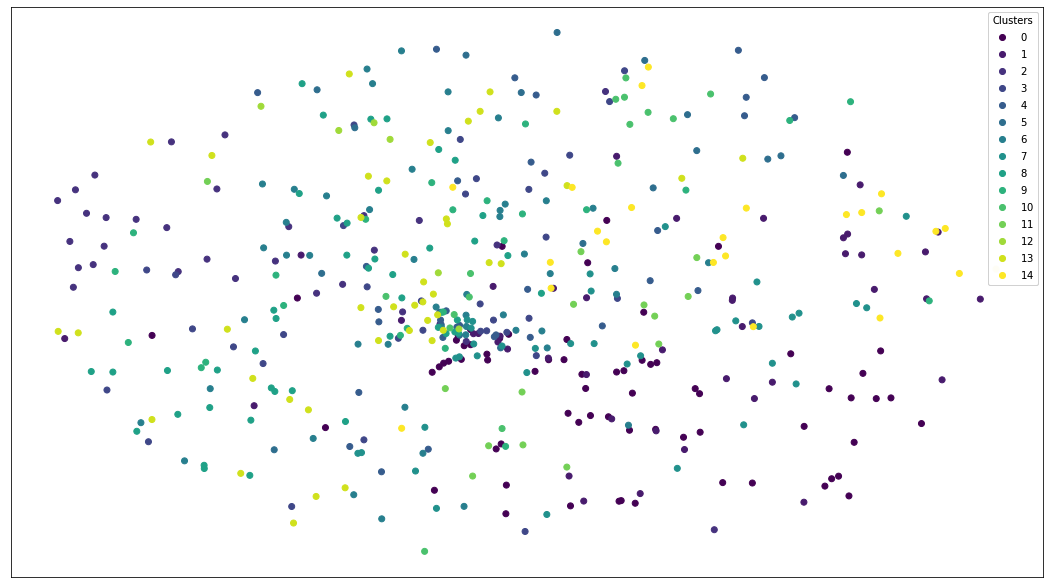

In [19]:
# Visualize

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
scatter = ax.scatter(y, z, c=x)
legend1 = ax.legend(*scatter.legend_elements(num=num_clusters),loc="upper right", title="Clusters")
ax.add_artist(legend1)
scatter.axes.xaxis.set_visible(False)
scatter.axes.yaxis.set_visible(False)

## Appendix: Unexplored/Unfinished Algorithms

In [20]:
# DBScan Pipeline

# Define number of clusters to show (note number of clusters is automatically determined)
num_clusters = 75

# Reduce Dimentions using TSNE
topics_red = reduce_dims(topics_embeddings,alg='tsne',num_components=3)

# Apply DBScan Clustering
cluster_assignment = dbscan(data=topics_embeddings) # data=topics_embeddings, topics_red

clust_col_name = 'DBScan Cluster'
df[clust_col_name] = cluster_assignment

# Refine the clusters using LCS
#df_refined = refine_clusters(df, num_clusters, clust_col_name)
#df_refined = df_refined[['Text', 'Topic', clust_col_name]]
#df_refined.reset_index(drop=True, inplace=True)

display(df)

# Print clusters cohesively
#print_clusters(num_clusters, df_refined, clust_col_name, 5)

# Save data as CSV
#df_refined.to_csv(data_path[:-4]+'.csv')

,Text,Topic,KMeans Cluster,DBScan Cluster
0,Home Service. This option is slightly more pro...,home service,4,0
1,Custom T-shirt printing. This option costs alm...,custom t-shirt printing,3,0
2,A Beauty Salon. This is another quite profitab...,a beauty salon,8,0
3,Dry Cleaning. This business can range from $20...,dry cleaning,13,0
4,Con-crete Company. One may get the required eq...,con-crete company,1,0
...,...,...,...,...
482,"Carpentry Shop. For as low as $4000, one can s...",carpentry shop,3,0
483,Jewelry and costume shop. One could purchase a...,jewelry and costume shop,11,0
484,Small Retail. If one starts this business with...,small retail,7,0
485,"Custom Fabric. For as low as $2000, one might ...",custom fabric,3,0
